In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Generating Parameters

In [4]:
with open('../req-files/config_e15503b_p_NOTILT.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']
print(beam_origin_z)
gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 1000

1.14


In [5]:
#Generator Python object
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [6]:
#for params in pgen:
#    print(params)

In [85]:
# of the form ([x0, y0, z0, enu0, azi0, pol0], [beam vector (3d)])
p = next(pgen)

p[0][0] = 0.0
p[0][1] =  0.0
p[0][2] = 0.75
#p[0][3] = 1.83097548
#p[0][4] =  0.11137931
#p[0][5] =  2.01473709

#print(p)
#print(p[0]) # [x0, y0, z0, enu0, azi0, pol0]
print(p[0][2]) # [beam vector (3d)] ?? x,y,z?

0.75


In [86]:
sim = EventSimulator(config)

In [87]:
#Creating simulated spiral from track parameters
#Finds center with an analytical function
#Uses EventGenerator to project the spiral onto the pad plane
evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

evtNoiseNOCLIP, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

evtDepressNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtGaussianNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtClipNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])


In [88]:
#print(len(evtClean))

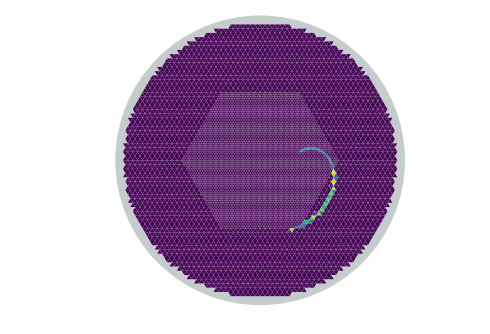

In [90]:
hits = np.zeros(10240)
for k, v in evtClean.items():
    #if hitmask[k]:
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
#plt.colorbar(sm)

#plt.savefig('../plots/thesis/trackOrientation8.png')

# Adding Noise

In [ ]:
#Adding keys/values to dictionary event object for missing pads
for padAddress in range(0,10240):
    if (padAddress not in evtClean):
        evtClean[padAddress] = np.zeros(512)
        evtNoise[padAddress] = np.zeros(512)
        evtGaussianNoise[padAddress] = np.zeros(512)
    else:
        print("Pad " + str(padAddress) + " already in event")

In [ ]:
print(len(evtClean))
print(len(evtNoise))
print(len(evtGaussianNoise))

In [ ]:
nm = NoiseMaker(config)

In [ ]:
%%capture
# (evt, depress_baseline, gaussian_noise, clip)

evtNoise = nm.add_noise(evtNoise, True, True, True)

evtNoiseNOCLIP = nm.add_noise(evtNoiseNOCLIP, True, True, False)

evtDepressNoise = nm.add_noise(evtDepressNoise, True, False, False)
evtGaussianNoise = nm.add_noise(evtGaussianNoise, False, True, False)
evtClipNoise = nm.add_noise(evtClipNoise, False, False, True)

In [ ]:
hits = np.zeros(10240)
for k, v in evtNoise.items():
    #if hitmask[k]:
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

#plt.savefig('/home/taylor/Documents/independent-research/event-gen/pad_plot.pdf')

# Converting simulated events to Event objects

In [ ]:
pyevtClean = sim.convert_event(evtClean)
pyevtNoise = sim.convert_event(evtNoise)

pyevtNoiseNOCLIP = sim.convert_event(evtNoiseNOCLIP)

pyevtDepressNoise = sim.convert_event(evtDepressNoise)
pyevtGaussianNoise = sim.convert_event(evtGaussianNoise)
pyevtClipNoise = sim.convert_event(evtClipNoise)

In [ ]:
print(pyevtClean)
print(pyevtNoise)
print(pyevtDepressNoise)
print(pyevtGaussianNoise)
print(pyevtClipNoise)

# Plots

In [ ]:
new_xyzs = print
plt.plot(new_xyzs[:,0], new_xyzs[:,1], '.')
plt.axis('equal')
    
plt.title('A Simulated Event')
    
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

In [ ]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,0], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
new_xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(new_xyzs_Noise[:,0], new_xyzs_Noise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Noise')
    
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pxy.pdf')

In [ ]:
new_xyzs = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
plt.plot(new_xyzs[:,2], new_xyzs[:,1], '.')
plt.axis('equal')
    
plt.title('A Simulated Event')
    
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')

In [ ]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,2], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
new_xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(new_xyzs_Noise[:,2], new_xyzs_Noise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pzy.pdf')

In [ ]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,2], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
xyzs_NoiseNOCLIP = pyevtNoiseNOCLIP.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(xyzs_NoiseNOCLIP[:,2], xyzs_NoiseNOCLIP[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event Baseline Depression and Random Gaussian Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_pzy.pdf')

In [ ]:
fig, ax = plt.subplots(1, 5, squeeze=True, figsize=(30, 6))

xyzs_clean = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(xyzs_clean[:,2], xyzs_clean[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
xyzs_DepressNoise = pyevtDepressNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(xyzs_DepressNoise[:,2], xyzs_DepressNoise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Baseline Depression Noise')
    
ax[1].set_xlabel('z [mm]')
ax[1].set_ylabel('y [mm]')

####################################################################################################################
xyzs_GaussianNoise = pyevtGaussianNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[2].plot(xyzs_GaussianNoise[:,2], xyzs_GaussianNoise[:,1], '.')
ax[2].axis('equal')
    
ax[2].set_title('A Simulated Event w/ Random Gaussian Noise')
    
ax[2].set_xlabel('z [mm]')
ax[2].set_ylabel('y [mm]')

####################################################################################################################
xyzs_ClipNoise = pyevtClipNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[3].plot(xyzs_ClipNoise[:,2], xyzs_ClipNoise[:,1], '.')
ax[3].axis('equal')
    
ax[3].set_title('A Simulated Event w/ Pedestal Clip Noise')
    
ax[3].set_xlabel('z [mm]')
ax[3].set_ylabel('y [mm]')

####################################################################################################################
xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[4].plot(xyzs_Noise[:,2], xyzs_Noise[:,1], '.')
ax[4].axis('equal')
    
ax[4].set_title('A Simulated Event w/ All Noise')
    
ax[4].set_xlabel('z [mm]')
ax[4].set_ylabel('y [mm]')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/separateNoiseCompare_stDev5e-1.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

new_xyzs = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#print(len(new_xyzs[:,2]))
ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])
ax.axis('equal')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_p3d_Noise.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#print(len(new_xyzs[:,2]))
ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])
ax.axis('equal')

#fig.savefig('/home/taylor/Documents/independent-research/event-gen/plots/noiseCompare_p3d.pdf')

In [ ]:
#fig = plt.figure()

#ax = fig.add_subplot(111, projection='3d')
#new_xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#ax.scatter(new_xyzs[:,0], new_xyzs[:,1],new_xyzs[:,2])

#new_xyzs_noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
#ax.scatter(new_xyzs_noise[:,0], new_xyzs_noise[:,1],new_xyzs_noise[:,2], 
#           c = ('blue' if (new_xyzs_noise[:,0] in new_xyzs) else 'red'))

#ax.axis('equal')

In [ ]:
new_xyzs_noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

chamber_plot(new_xyzs_noise[:])
#plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/chamber_plot.pdf')

In [ ]:
#for trace in pyevtClean.traces['data']:
#    plt.plot(trace)

In [ ]:
#for trace in pyevtGaussianNoise.traces['data']:
#    plt.plot(trace)

In [ ]:
tr = pyevtClean.traces['data'][3776]
plt.plot(tr)


In [ ]:
tr1 = pyevtGaussianNoise.traces['data'][3776]
plt.plot(tr1)
#plt.xlim(-10,100)

In [ ]:
tr2 = pyevtGaussianNoise.traces['data'][0]
plt.plot(tr2)

In [ ]:
tr2 = pyevtDepressNoise.traces['data'][0]
plt.plot(tr2)

In [ ]:
tr2 = pyevtClipNoise.traces['data'][0]
plt.plot(tr2)